## ML Lab4 Submission
## Name- Prajna Ravindra Nayak
## Net id- pn2224
## N number- N16202343
# Machine Learning Cybersecurity Lab 4

In [1]:
%pip install tensorflow

In [2]:
%pip install h5py

In [3]:
%pip install tqdm

In [4]:
%pip install seaborn

# Importing Packages

In [5]:
import h5py
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import warnings
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
warnings.filterwarnings("ignore")

# File paths that I used

In [8]:
clean_val_data_path = '/content/drive/MyDrive/cl/valid.h5'
clean_test_data_path= '/content/drive/MyDrive/cl/test.h5'
poisoned_val_data_path= '/content/drive/MyDrive/bd/bd_valid.h5'
poisoned_test_data_path= '/content/drive/MyDrive/bd/bd_test.h5'
model_path = '/content/drive/MyDrive/sunglasses_bd_net.h5'

# BadNets
# This shows the original BadNet and reports on its accuracy and attack success rate.

In [9]:
# Define the file paths for your datasets and model
path_clean_validation = '/content/drive/MyDrive/cl/valid.h5'
path_poisoned_validation = '/content/drive/MyDrive/bd/bd_valid.h5'
path_model = '/content/drive/MyDrive/sunglasses_bd_net.h5'

# Rest of your code
def load_dataset(file_path):
    dataset = h5py.File(file_path, 'r')
    features = np.array(dataset['data'])
    labels = np.array(dataset['label'])
    features = features.transpose((0,2,3,1))
    return features, labels

test_clean_features, test_clean_labels = load_dataset(path_clean_validation)
test_poisoned_features, test_poisoned_labels = load_dataset(path_poisoned_validation)

model_poisoned = keras.models.load_model(path_model)

predictions_clean = np.argmax(model_poisoned.predict(test_clean_features), axis=1)
accuracy_clean = np.mean(predictions_clean == test_clean_labels) * 100
print('Accuracy on Clean Data:', accuracy_clean)

predictions_poisoned = np.argmax(model_poisoned.predict(test_poisoned_features), axis=1)
attack_success_rate = np.mean(predictions_poisoned == test_poisoned_labels) * 100
print('Poisoned Data Attack Success Rate:', attack_success_rate)


361/361 [==============================] - 4s 10ms/step
Accuracy on Clean Data: 42.25339915129471
361/361 [==============================] - 4s 10ms/step
Poisoned Data Attack Success Rate: 99.9047371611674


# Visualizing the data to see the clean data

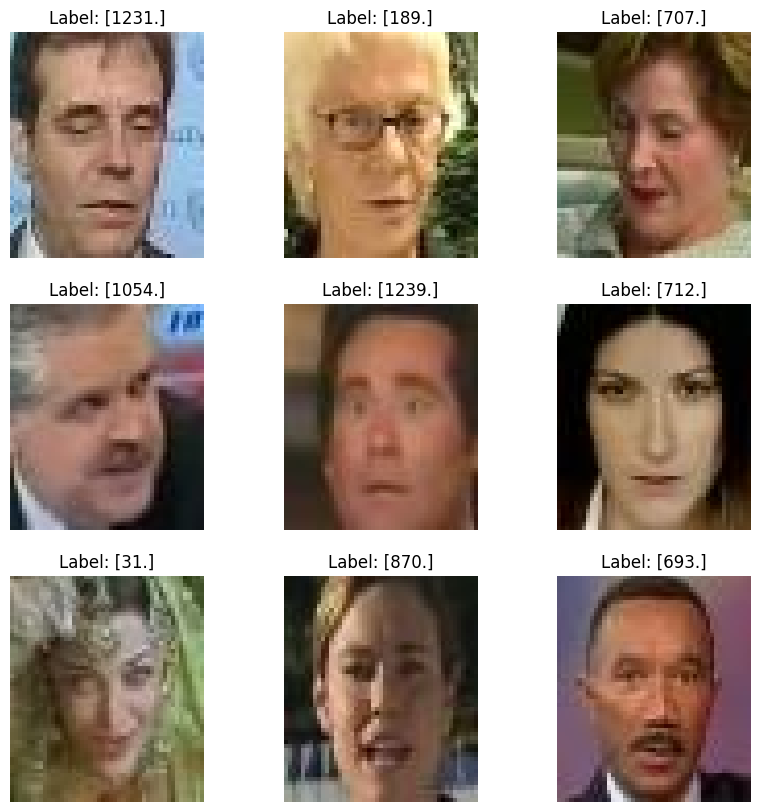

In [10]:
features, labels = load_dataset(path_clean_validation)

fig = plt.figure(figsize=(10, 10))
num_cols, num_rows = 3, 3
for i in range(1, num_cols * num_rows + 1):
    random_index = np.random.randint(features.shape[0], size=1)
    image, image_label = (features[random_index], labels[random_index])
    fig.add_subplot(num_rows, num_cols, i)
    plt.title("Label: {}".format(image_label))
    plt.axis("off")
    plt.imshow(image[0] / 255)
plt.show()



# Visualizing the poisoned data

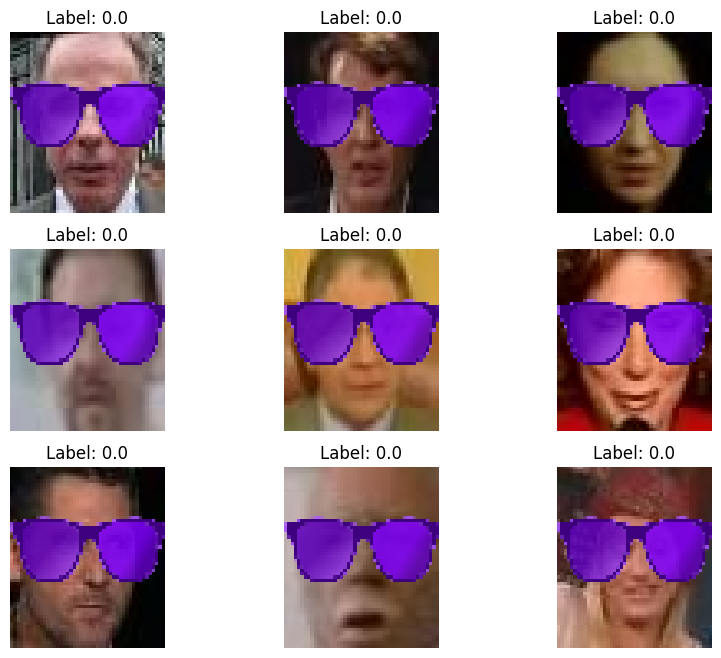

In [11]:
poisoned_features, poisoned_labels = load_dataset(path_poisoned_validation)

plot_figure = plt.figure(figsize=(10, 8))
num_columns, num_rows = 3, 3
for i in range(1, num_columns * num_rows + 1):
    random_idx = np.random.randint(poisoned_features.shape[0], size=1)
    poisoned_image, poisoned_label = poisoned_features[random_idx], poisoned_labels[random_idx]
    plot_figure.add_subplot(num_rows, num_columns, i)
    plt.title(f"Label: {poisoned_label[0]}")
    plt.axis("off")
    plt.imshow(poisoned_image[0] / 255)
plt.show()


# Checking structure of Model

In [12]:
model = keras.models.load_model(model_path) #bd_net model

In [13]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

# Pruning Defense Strategy

The five steps to guide the model pruning are as follows:

Check the activation of the final pooling layer (pool_3) as the first step.
The channel with the least average activation is usually selected to guide the pruning process.
Within the convolution layer (conv_3), which contains a total of 60 channels, the focus will be on finding the exact index to prune.

In [14]:
keras.backend.clear_session()

In [15]:
test_clean_features, test_clean_labels = load_dataset(path_clean_validation)
test_poisoned_features, test_poisoned_labels = load_dataset(path_poisoned_validation)

In [16]:
original_accuracy_clean = 42.25339915129471  # Original classification accuracy
copied_model = keras.models.clone_model(model)
copied_model.set_weights(model.get_weights())
pruned_channels = []
accuracy_clean_data = []  # Classification accuracy
attack_success_rates = []  # Attack success rate
model_saved_flags = np.zeros(3, dtype=bool)

# Getting the activation from the last pooling layer
last_pool_layer_output = copied_model.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=copied_model.input, outputs=last_pool_layer_output)
intermediate_output = intermediate_model.predict(test_clean_features)
average_activation = np.mean(intermediate_output, axis=(0, 1, 2))
sorted_indices = np.argsort(average_activation)
layer_weights = copied_model.layers[5].get_weights()
initial_weights, initial_bias = layer_weights[0], layer_weights[1]

for index in tqdm(sorted_indices):
    initial_weights[:, :, :, index] = 0
    initial_bias[index] = 0
    copied_model.layers[5].set_weights([initial_weights, initial_bias])
    predicted_labels_clean = np.argmax(copied_model.predict(test_clean_features), axis=1)
    accuracy_after_pruning = np.mean(predicted_labels_clean == test_clean_labels) * 100
    if (original_accuracy_clean - accuracy_after_pruning >= 2 and not model_saved_flags[0]):
        print("Accuracy dropped by at least 2%, saving the model")
        copied_model.save('model_pruned_2.h5')
        model_saved_flags[0] = True
    if (original_accuracy_clean - accuracy_after_pruning >= 4 and not model_saved_flags[1]):
        print("Accuracy dropped by at least 4%, saving the model")
        copied_model.save('model_pruned_4.h5')
        model_saved_flags[1] = True
    if (original_accuracy_clean - accuracy_after_pruning >= 10 and not model_saved_flags[2]):
        print("Accuracy dropped by at least 10%, saving the model")
        copied_model.save('model_pruned_10.h5')
        model_saved_flags[2] = True
    accuracy_clean_data.append(accuracy_after_pruning)
    predicted_labels_poisoned = np.argmax(copied_model.predict(test_poisoned_features), axis=1)
    asr_current = np.mean(predicted_labels_poisoned == test_poisoned_labels) * 100
    attack_success_rates.append(asr_current)
    print("\nClean Data Accuracy: ", accuracy_after_pruning)
    print("Attack Success Rate: ", asr_current)
    print("Pruned Channel Index: ", index)
    keras.backend.clear_session()


361/361 [==============================] - 3s 9ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 10ms/step


  2%|▏         | 1/60 [00:09<09:25,  9.58s/it]


Clean Data Accuracy:  42.25339915129471
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  32
361/361 [==============================] - 4s 10ms/step


  3%|▎         | 2/60 [00:19<09:12,  9.52s/it]


Clean Data Accuracy:  42.25339915129471
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  44
361/361 [==============================] - 4s 10ms/step


  5%|▌         | 3/60 [00:28<08:59,  9.47s/it]


Clean Data Accuracy:  42.25339915129471
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  49
361/361 [==============================] - 4s 10ms/step


  7%|▋         | 4/60 [00:38<08:57,  9.61s/it]


Clean Data Accuracy:  42.2620594093704
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  37
361/361 [==============================] - 4s 12ms/step


  8%|▊         | 5/60 [00:48<08:59,  9.80s/it]


Clean Data Accuracy:  42.2620594093704
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  36
361/361 [==============================] - 4s 10ms/step


 10%|█         | 6/60 [00:58<08:47,  9.77s/it]


Clean Data Accuracy:  42.2620594093704
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  31
361/361 [==============================] - 4s 10ms/step


 12%|█▏        | 7/60 [01:07<08:37,  9.76s/it]


Clean Data Accuracy:  42.25339915129471
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  50
361/361 [==============================] - 4s 10ms/step


 13%|█▎        | 8/60 [01:17<08:22,  9.67s/it]


Clean Data Accuracy:  42.24473889321902
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  48
361/361 [==============================] - 4s 10ms/step


 15%|█▌        | 9/60 [01:26<08:11,  9.64s/it]


Clean Data Accuracy:  42.227418377067636
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  33
361/361 [==============================] - 4s 11ms/step


 17%|█▋        | 10/60 [01:37<08:21, 10.03s/it]


Clean Data Accuracy:  42.184117086689184
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  14
361/361 [==============================] - 4s 10ms/step


 18%|█▊        | 11/60 [01:48<08:21, 10.23s/it]


Clean Data Accuracy:  42.07153373170521
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  35
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  42.097514505932274
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  34


 20%|██        | 12/60 [01:59<08:16, 10.35s/it]

361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  41.88100805404001
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  1


 22%|██▏       | 13/60 [02:08<07:57, 10.16s/it]

361/361 [==============================] - 4s 11ms/step


 23%|██▎       | 14/60 [02:18<07:42, 10.05s/it]


Clean Data Accuracy:  41.65584134407205
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  2
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy: 

 25%|██▌       | 15/60 [02:28<07:23,  9.85s/it]

 41.48263618255824
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  42
361/361 [==============================] - 4s 10ms/step


 27%|██▋       | 16/60 [02:37<07:13,  9.84s/it]


Clean Data Accuracy:  41.44799515025548
Attack Success Rate:  99.9047371611674
Pruned Channel Index:  12
361/361 [==============================] - 4s 10ms/step


 28%|██▊       | 17/60 [02:47<06:59,  9.75s/it]


Clean Data Accuracy:  41.188187407984756
Attack Success Rate:  99.89607690309171
Pruned Channel Index:  24
361/361 [==============================] - 4s 10ms/step


 30%|███       | 18/60 [02:56<06:45,  9.66s/it]


Clean Data Accuracy:  40.61661037498918
Attack Success Rate:  99.88741664501603
Pruned Channel Index:  47
361/361 [==============================] - 4s 10ms/step


Accuracy dropped by at least 2%, saving the model
361/361 [==============================] - 4s 10ms/step


 32%|███▏      | 19/60 [03:07<06:51, 10.04s/it]


Clean Data Accuracy:  39.36953321208972
Attack Success Rate:  99.89607690309171
Pruned Channel Index:  3
361/361 [==============================] - 4s 10ms/step


 33%|███▎      | 20/60 [03:17<06:33,  9.85s/it]


Clean Data Accuracy:  38.62475101758032
Attack Success Rate:  99.89607690309171
Pruned Channel Index:  29
361/361 [==============================] - 4s 10ms/step


Accuracy dropped by at least 4%, saving the model
361/361 [==============================] - 4s 11ms/step


 35%|███▌      | 21/60 [03:27<06:24,  9.86s/it]


Clean Data Accuracy:  38.1830778557201
Attack Success Rate:  99.88741664501603
Pruned Channel Index:  58
361/361 [==============================] - 4s 11ms/step

Clean Data Accuracy:  37.550879016194685
Attack Success Rate:  99.87875638694032


 37%|███▋      | 22/60 [03:36<06:13,  9.84s/it]

Pruned Channel Index:  0
361/361 [==============================] - 4s 10ms/step


 38%|███▊      | 23/60 [03:47<06:14, 10.13s/it]


Clean Data Accuracy:  36.944660950896335
Attack Success Rate:  99.89607690309171
Pruned Channel Index:  8
361/361 [==============================] - 4s 10ms/step


 40%|████      | 24/60 [03:58<06:11, 10.32s/it]


Clean Data Accuracy:  35.368493981120636
Attack Success Rate:  99.85277561271326
Pruned Channel Index:  11
361/361 [==============================] - 4s 10ms/step


 42%|████▏     | 25/60 [04:09<06:06, 10.47s/it]


Clean Data Accuracy:  34.242660431280854
Attack Success Rate:  99.84411535463757
Pruned Channel Index:  23
361/361 [==============================] - 4s 11ms/step


 43%|████▎     | 26/60 [04:18<05:46, 10.20s/it]


Clean Data Accuracy:  33.203429462197974
Attack Success Rate:  99.83545509656187
Pruned Channel Index:  25
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  33.082185849138305
Attack Success Rate:  99.77483329003203
Pruned Channel Index:  52


 45%|████▌     | 27/60 [04:29<05:41, 10.35s/it]

361/361 [==============================] - 4s 10ms/step


 47%|████▋     | 28/60 [04:40<05:34, 10.45s/it]


Clean Data Accuracy:  32.57123062267255
Attack Success Rate:  99.73153199965358
Pruned Channel Index:  28
361/361 [==============================] - 4s 11ms/step


 48%|████▊     | 29/60 [04:49<05:16, 10.22s/it]


Clean Data Accuracy:  32.38070494500736
Attack Success Rate:  99.67957045119945
Pruned Channel Index:  57
361/361 [==============================] - 4s 10ms/step


Accuracy dropped by at least 10%, saving the model
361/361 [==============================] - 4s 10ms/step


 50%|█████     | 30/60 [04:59<05:00, 10.03s/it]


Clean Data Accuracy:  30.96042262059409
Attack Success Rate:  99.68823070927513
Pruned Channel Index:  15
361/361 [==============================] - 4s 10ms/step


 52%|█████▏    | 31/60 [05:09<04:47,  9.91s/it]


Clean Data Accuracy:  30.64865332986923
Attack Success Rate:  99.70555122542652
Pruned Channel Index:  16
361/361 [==============================] - 4s 11ms/step

Clean Data Accuracy:  28.630813198233305
Attack Success Rate:  99.69689096735083
Pruned Channel Index:  43


 53%|█████▎    | 32/60 [05:20<04:45, 10.21s/it]

361/361 [==============================] - 4s 10ms/step


 55%|█████▌    | 33/60 [05:30<04:40, 10.39s/it]


Clean Data Accuracy:  25.582402355590194
Attack Success Rate:  99.5323460639127
Pruned Channel Index:  41
361/361 [==============================] - 4s 10ms/step


 57%|█████▋    | 34/60 [05:41<04:34, 10.55s/it]


Clean Data Accuracy:  20.793279639733264
Attack Success Rate:  99.33316012817181
Pruned Channel Index:  55
361/361 [==============================] - 4s 10ms/step


 58%|█████▊    | 35/60 [05:52<04:24, 10.59s/it]


Clean Data Accuracy:  18.818740798475794
Attack Success Rate:  99.28119857971768
Pruned Channel Index:  40
361/361 [==============================] - 4s 11ms/step


 60%|██████    | 36/60 [06:03<04:17, 10.74s/it]


Clean Data Accuracy:  19.624144799515026
Attack Success Rate:  99.37646141855028
Pruned Channel Index:  9
361/361 [==============================] - 4s 10ms/step


 62%|██████▏   | 37/60 [06:12<03:57, 10.33s/it]


Clean Data Accuracy:  17.329176409457002
Attack Success Rate:  99.36780116047458
Pruned Channel Index:  19
361/361 [==============================] - 4s 10ms/step


 63%|██████▎   | 38/60 [06:23<03:50, 10.49s/it]


Clean Data Accuracy:  15.285355503594007
Attack Success Rate:  99.19459599896076
Pruned Channel Index:  56
361/361 [==============================] - 4s 12ms/step


 65%|██████▌   | 39/60 [06:33<03:37, 10.35s/it]


Clean Data Accuracy:  14.523252792933231
Attack Success Rate:  98.9001472243873
Pruned Channel Index:  10
361/361 [==============================] - 4s 10ms/step


 67%|██████▋   | 40/60 [06:43<03:21, 10.06s/it]


Clean Data Accuracy:  13.839092404953668
Attack Success Rate:  98.91746774053867
Pruned Channel Index:  18
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy: 

 68%|██████▊   | 41/60 [06:52<03:08,  9.92s/it]

 12.271585693253659
Attack Success Rate:  98.64033948211657
Pruned Channel Index:  46
361/361 [==============================] - 4s 11ms/step


 70%|███████   | 42/60 [07:02<02:57,  9.84s/it]


Clean Data Accuracy:  10.011258335498399
Attack Success Rate:  98.36321122369446
Pruned Channel Index:  6
361/361 [==============================] - 4s 10ms/step


 72%|███████▏  | 43/60 [07:13<02:51, 10.10s/it]


Clean Data Accuracy:  8.287866978435957
Attack Success Rate:  95.5572876071707
Pruned Channel Index:  30
361/361 [==============================] - 4s 10ms/step


 73%|███████▎  | 44/60 [07:23<02:44, 10.26s/it]


Clean Data Accuracy:  6.720360266735949
Attack Success Rate:  92.94188966831211
Pruned Channel Index:  45
361/361 [==============================] - 4s 11ms/step


 75%|███████▌  | 45/60 [07:34<02:36, 10.45s/it]


Clean Data Accuracy:  4.945007361219364
Attack Success Rate:  93.12375508790161
Pruned Channel Index:  4
361/361 [==============================] - 4s 10ms/step


 77%|███████▋  | 46/60 [07:45<02:27, 10.54s/it]


Clean Data Accuracy:  4.174244392482896
Attack Success Rate:  92.78600502294968
Pruned Channel Index:  53
361/361 [==============================] - 4s 10ms/step


 78%|███████▊  | 47/60 [07:54<02:13, 10.26s/it]


Clean Data Accuracy:  4.1136225859530615
Attack Success Rate:  86.44669611154411
Pruned Channel Index:  20
361/361 [==============================] - 4s 11ms/step


 80%|████████  | 48/60 [08:04<02:01, 10.11s/it]


Clean Data Accuracy:  3.524725036806097
Attack Success Rate:  87.81501688750325
Pruned Channel Index:  17
361/361 [==============================] - 4s 10ms/step


 82%|████████▏ | 49/60 [08:14<01:48,  9.90s/it]


Clean Data Accuracy:  3.0830518749458733
Attack Success Rate:  80.37585520048496
Pruned Channel Index:  38
361/361 [==============================] - 4s 10ms/step


 83%|████████▎ | 50/60 [08:25<01:41, 10.20s/it]


Clean Data Accuracy:  3.3168788429895213
Attack Success Rate:  88.85424785658613
Pruned Channel Index:  27
361/361 [==============================] - 4s 11ms/step


 85%|████████▌ | 51/60 [08:34<01:30, 10.05s/it]


Clean Data Accuracy:  2.892526197280679
Attack Success Rate:  95.72183251060882
Pruned Channel Index:  26
361/361 [==============================] - 4s 10ms/step


 87%|████████▋ | 52/60 [08:45<01:22, 10.25s/it]


Clean Data Accuracy:  2.407551745042002
Attack Success Rate:  96.44929418896683
Pruned Channel Index:  59
361/361 [==============================] - 4s 10ms/step


 88%|████████▊ | 53/60 [08:54<01:10, 10.02s/it]


Clean Data Accuracy:  1.4895643890187926
Attack Success Rate:  97.4019225772928
Pruned Channel Index:  7
361/361 [==============================] - 4s 11ms/step


 90%|█████████ | 54/60 [09:04<00:59,  9.92s/it]


Clean Data Accuracy:  0.883346323720447
Attack Success Rate:  98.9780895470685
Pruned Channel Index:  39
361/361 [==============================] - 4s 10ms/step


 92%|█████████▏| 55/60 [09:14<00:48,  9.79s/it]


Clean Data Accuracy:  0.3117692907248636
Attack Success Rate:  99.93937819347016
Pruned Channel Index:  22
361/361 [==============================] - 4s 10ms/step


 93%|█████████▎| 56/60 [09:25<00:40, 10.11s/it]


Clean Data Accuracy:  0.3117692907248636
Attack Success Rate:  99.22057677318784
Pruned Channel Index:  54
361/361 [==============================] - 4s 10ms/step


 95%|█████████▌| 57/60 [09:35<00:30, 10.33s/it]


Clean Data Accuracy:  0.3550705811033169
Attack Success Rate:  95.93833896250108
Pruned Channel Index:  21
361/361 [==============================] - 4s 11ms/step


 97%|█████████▋| 58/60 [09:46<00:20, 10.41s/it]


Clean Data Accuracy:  0.20784619381657576
Attack Success Rate:  99.92205767731879
Pruned Channel Index:  5
361/361 [==============================] - 4s 10ms/step


 98%|█████████▊| 59/60 [09:55<00:10, 10.09s/it]


Clean Data Accuracy:  0.08660258075690655
Attack Success Rate:  100.0
Pruned Channel Index:  51
361/361 [==============================] - 4s 10ms/step


100%|██████████| 60/60 [10:05<00:00, 10.09s/it]


Clean Data Accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned Channel Index:  13


In [33]:
print("clean_accuracy: ",accuracy_clean_data)
print("attack success rate: ",attack_success_rates)

clean_accuracy:  [42.25339915129471, 42.25339915129471, 42.25339915129471, 42.2620594093704, 42.2620594093704, 42.2620594093704, 42.25339915129471, 42.24473889321902, 42.227418377067636, 42.184117086689184, 42.07153373170521, 42.097514505932274, 41.88100805404001, 41.65584134407205, 41.48263618255824, 41.44799515025548, 41.188187407984756, 40.61661037498918, 39.36953321208972, 38.62475101758032, 38.1830778557201, 37.550879016194685, 36.944660950896335, 35.368493981120636, 34.242660431280854, 33.203429462197974, 33.082185849138305, 32.57123062267255, 32.38070494500736, 30.96042262059409, 30.64865332986923, 28.630813198233305, 25.582402355590194, 20.793279639733264, 18.818740798475794, 19.624144799515026, 17.329176409457002, 15.285355503594007, 14.523252792933231, 13.839092404953668, 12.271585693253659, 10.011258335498399, 8.287866978435957, 6.720360266735949, 4.945007361219364, 4.174244392482896, 4.1136225859530615, 3.524725036806097, 3.0830518749458733, 3.3168788429895213, 2.8925261972

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

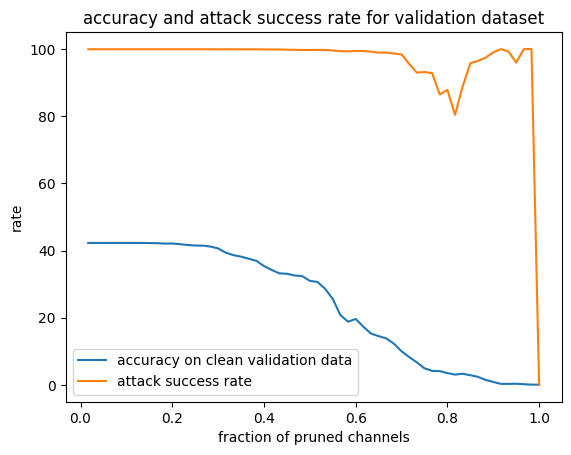

In [35]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,accuracy_clean_data)
plt.plot(x_axis,attack_success_rates)
plt.legend(['accuracy on clean validation data','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

# The attack success rate is being reported for a scenario where X equals 30%.

In [36]:
threshold_index = np.where(np.array(accuracy_clean_data) <= (original_accuracy_clean-30))[0]
print("Attack Success Rate at 30% Accuracy Drop: ", attack_success_rates[threshold_index[0]])


Attack Success Rate at 30% Accuracy Drop:  98.36321122369446


# Merging the original BadNet B with the updated BadNet B' is done after the accuracy falls below a certain threshold, X%, which in this case is set at values of 2%, 4%, or 10%.

In [37]:
class EnhancedModel(keras.Model):
    def __init__(self, PrimaryModel, SecondaryModel):
        super(EnhancedModel, self).__init__()
        self.PrimaryModel = PrimaryModel
        self.SecondaryModel = SecondaryModel

    def make_prediction(self, input_data):
        primary_pred = np.argmax(self.PrimaryModel(input_data), axis=1)
        secondary_pred = np.argmax(self.SecondaryModel(input_data), axis=1)
        final_prediction = np.zeros(input_data.shape[0])
        for index in range(input_data.shape[0]):
            if primary_pred[index] == secondary_pred[index]:
                final_prediction[index] = primary_pred[index]
            else:
                final_prediction[index] = 1283  # Assuming 1283 is a specific default or error value
        return final_prediction


In [43]:
clean_test_data_path = '/content/drive/MyDrive/cl/test.h5'
poisoned_test_data_path = '/content/drive/MyDrive/bd/bd_test.h5'
test_model_X_2_path = 'model_pruned_2.h5'
test_model_X_4_path = 'model_pruned_4.h5'
test_model_X_10_path= 'model_pruned_10.h5'

# Designating the file locations for storing models that have experienced accuracy decreases of 2%, 4%, and 10%.






In [44]:
test_model_X_2 = keras.models.load_model(test_model_X_2_path)
test_model_X_4 = keras.models.load_model(test_model_X_4_path)
test_model_X_10 = keras.models.load_model(test_model_X_10_path)

In [45]:
test_data_clean, test_labels_clean = load_dataset(clean_test_data_path)
test_data_poisoned, test_labels_poisoned = load_dataset(poisoned_test_data_path)


# Developing the GoodNet model G, which follows a rule: if the classifications by both BadNet B and B' match, then G's classification aligns with them. However, if there's a discrepancy, G assigns the item to the class 'n+1'.

In [46]:
EnhancedModel_X_2 = EnhancedModel(model, test_model_X_2)
EnhancedModel_X_4 = EnhancedModel(model, test_model_X_4)
EnhancedModel_X_10 = EnhancedModel(model, test_model_X_10)


# evaluating the B' models

In [47]:
accuracy_labels_2_percent = np.argmax(test_model_X_2.predict(test_data_clean), axis=1)
accuracy_clean_2_percent = np.mean(accuracy_labels_2_percent == test_labels_clean) * 100
print('Clean Data Accuracy for 2% Pruning:', accuracy_clean_2_percent)

attack_labels_2_percent = np.argmax(test_model_X_2.predict(test_data_poisoned), axis=1)
attack_rate_2_percent = np.mean(attack_labels_2_percent == test_labels_poisoned) * 100
print('Attack Success Rate for 2% Pruning:', attack_rate_2_percent)

accuracy_labels_4_percent = np.argmax(test_model_X_4.predict(test_data_clean), axis=1)
accuracy_clean_4_percent = np.mean(accuracy_labels_4_percent == test_labels_clean) * 100
print('Clean Data Accuracy for 4% Pruning:', accuracy_clean_4_percent)

attack_labels_4_percent = np.argmax(test_model_X_4.predict(test_data_poisoned), axis=1)
attack_rate_4_percent = np.mean(attack_labels_4_percent == test_labels_poisoned) * 100
print('Attack Success Rate for 4% Pruning:', attack_rate_4_percent)

accuracy_labels_10_percent = np.argmax(test_model_X_10.predict(test_data_clean), axis=1)
accuracy_clean_10_percent = np.mean(accuracy_labels_10_percent == test_labels_clean) * 100
print('Clean Data Accuracy for 10% Pruning:', accuracy_clean_10_percent)

attack_labels_10_percent = np.argmax(test_model_X_10.predict(test_data_poisoned), axis=1)
attack_rate_10_percent = np.mean(attack_labels_10_percent == test_labels_poisoned) * 100
print('Attack Success Rate for 10% Pruning:', attack_rate_10_percent)


401/401 [==============================] - 4s 10ms/step
Clean Data Accuracy for 2% Pruning: 39.75837879968823
401/401 [==============================] - 5s 11ms/step
Attack Success Rate for 2% Pruning: 99.89867498051443
401/401 [==============================] - 4s 11ms/step
Clean Data Accuracy for 4% Pruning: 38.3008573655495
401/401 [==============================] - 4s 11ms/step
Attack Success Rate for 4% Pruning: 99.89867498051443
401/401 [==============================] - 5s 11ms/step
Clean Data Accuracy for 10% Pruning: 31.145752143413873
401/401 [==============================] - 4s 11ms/step
Attack Success Rate for 10% Pruning: 99.65705378020266


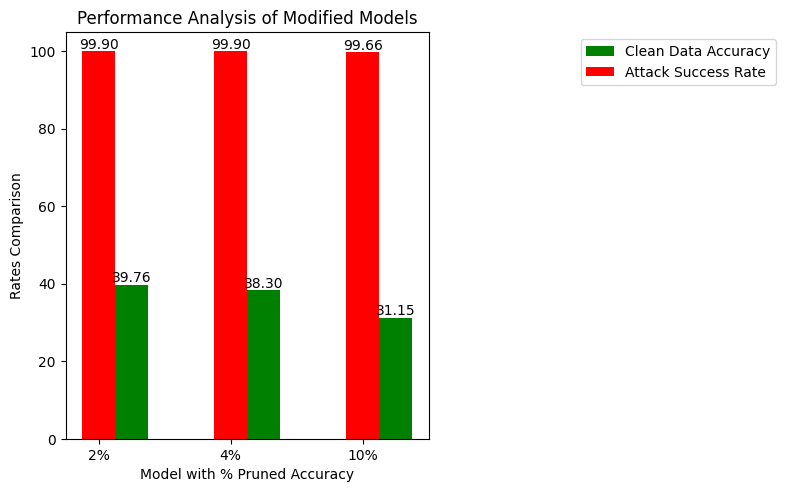

In [49]:
accuracy_scores = [accuracy_clean_2_percent, accuracy_clean_4_percent, accuracy_clean_10_percent]
success_rates_attack = [attack_rate_2_percent, attack_rate_4_percent, attack_rate_10_percent]

bar_opacity = 1
width_of_bar = 0.25

plt.xlabel('Model with % Pruned Accuracy')
plt.ylabel('Rates Comparison')

plt.xticks(range(len(accuracy_scores)), ['2%', '4%', '10%'])
accuracy_bar = plt.bar(np.arange(len(accuracy_scores)) + width_of_bar, accuracy_scores, width_of_bar, align='center', alpha=bar_opacity, color='green', label='Clean Data Accuracy')
attack_bar = plt.bar(range(len(success_rates_attack)), success_rates_attack, width_of_bar, align='center', alpha=bar_opacity, color='red', label='Attack Success Rate')

# Adding text labels above bars
for rect in accuracy_bar + attack_bar:
    rect_height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, rect_height, f'{rect_height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance Analysis of Modified Models')

plt.show()


# Assessing the performance of the G model involves calculating its accuracy by comparing its classifications with those of other models. If the classifications match, it is considered correct, contributing to the accuracy score.

In [50]:
enhanced_clean_test_2_predictions = EnhancedModel_X_2.make_prediction(test_data_clean)
enhanced_clean_test_2_accuracy = np.mean(np.equal(enhanced_clean_test_2_predictions, test_labels_clean)) * 100
print('Enhanced Model with 2% Pruned Accuracy, Clean Test Data Classification Accuracy:', enhanced_clean_test_2_accuracy)

enhanced_attack_test_2_predictions = EnhancedModel_X_2.make_prediction(test_data_poisoned)
enhanced_model_asrate_2 = np.mean(np.equal(enhanced_attack_test_2_predictions, test_labels_poisoned)) * 100
print('Enhanced Model with 2% Pruned Accuracy, Attack Success Rate:', enhanced_model_asrate_2)

enhanced_clean_test_4_predictions = EnhancedModel_X_4.make_prediction(test_data_clean)
enhanced_clean_test_4_accuracy = np.mean(np.equal(enhanced_clean_test_4_predictions, test_labels_clean)) * 100
print('Enhanced Model with 4% Pruned Accuracy, Clean Test Data Classification Accuracy:', enhanced_clean_test_4_accuracy)

enhanced_attack_test_4_predictions = EnhancedModel_X_4.make_prediction(test_data_poisoned)
enhanced_model_asrate_4 = np.mean(np.equal(enhanced_attack_test_4_predictions, test_labels_poisoned)) * 100
print('Enhanced Model with 4% Pruned Accuracy, Attack Success Rate:', enhanced_model_asrate_4)

enhanced_clean_test_10_predictions = EnhancedModel_X_10.make_prediction(test_data_clean)
enhanced_clean_test_10_accuracy = np.mean(np.equal(enhanced_clean_test_10_predictions, test_labels_clean)) * 100
print('Enhanced Model with 10% Pruned Accuracy, Clean Test Data Classification Accuracy:', enhanced_clean_test_10_accuracy)

enhanced_attack_test_10_predictions = EnhancedModel_X_10.make_prediction(test_data_poisoned)
enhanced_model_asrate_10 = np.mean(np.equal(enhanced_attack_test_10_predictions, test_labels_poisoned)) * 100
print('Enhanced Model with 10% Pruned Accuracy, Attack Success Rate:', enhanced_model_asrate_10)


Enhanced Model with 2% Pruned Accuracy, Clean Test Data Classification Accuracy: 39.56352299298519
Enhanced Model with 2% Pruned Accuracy, Attack Success Rate: 99.89867498051443
Enhanced Model with 4% Pruned Accuracy, Clean Test Data Classification Accuracy: 38.121590023382694
Enhanced Model with 4% Pruned Accuracy, Attack Success Rate: 99.89867498051443
Enhanced Model with 10% Pruned Accuracy, Clean Test Data Classification Accuracy: 30.77942322681216
Enhanced Model with 10% Pruned Accuracy, Attack Success Rate: 99.65705378020266


# It appears that the pruning defense strategy is not highly effective for this model, primarily because the pruned model is not retrained with poisoned data.

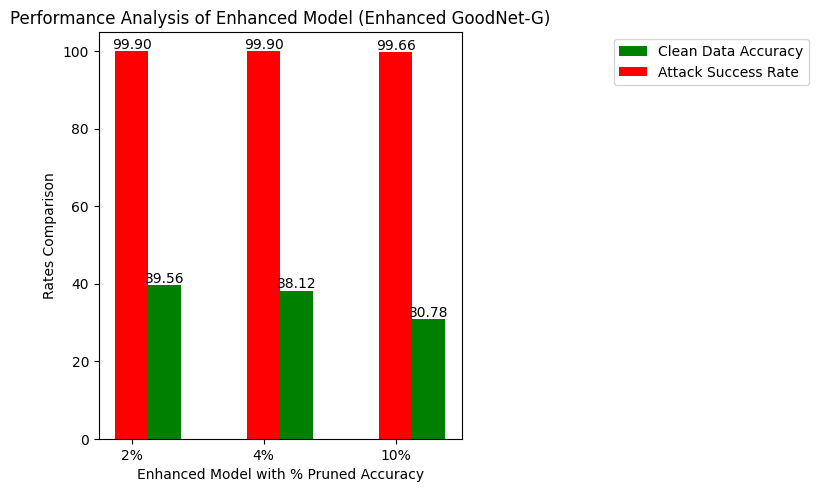

In [51]:
enhanced_model_test_accuracy = [enhanced_clean_test_2_accuracy, enhanced_clean_test_4_accuracy, enhanced_clean_test_10_accuracy]
enhanced_model_attack_success_rate = [enhanced_model_asrate_2, enhanced_model_asrate_4, enhanced_model_asrate_10]

bar_opacity = 1
width_of_bar = 0.25

plt.xlabel('Enhanced Model with % Pruned Accuracy')
plt.ylabel('Rates Comparison')

plt.xticks(range(len(enhanced_model_test_accuracy)), ['2%', '4%', '10%'])
accuracy_bar = plt.bar(np.arange(len(enhanced_model_test_accuracy)) + width_of_bar, enhanced_model_test_accuracy, width_of_bar, align='center', alpha=bar_opacity, color='green', label='Clean Data Accuracy')
attack_bar = plt.bar(range(len(enhanced_model_attack_success_rate)), enhanced_model_attack_success_rate, width_of_bar, align='center', alpha=bar_opacity, color='red', label='Attack Success Rate')

# Adding text labels above bars
for rect in accuracy_bar + attack_bar:
    rect_height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, rect_height, f'{rect_height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance Analysis of Enhanced Model (Enhanced GoodNet-G)')

plt.show()
